In [3]:
import numpy as np
import pandas as pd
import xarray as xr

# # Set the dimensions for x, y, and time
# x_dim = 9  # Number of elements along the x dimension
# y_dim = 11  # Number of elements along the y dimension
# time_dim = pd.date_range(
#     start="2020-01-01", end="2024-01-01", freq="ME"
# )  # Monthly frequency

# np.random.seed(seed=42)

# # Generate random data
# data = np.random.random(size=(len(time_dim), y_dim, x_dim)) * 100

# # Create the xarray DataArray
# data = xr.DataArray(
#     data,
#     dims=["time", "y", "x"],
#     coords={"time": time_dim, "x": np.arange(x_dim), "y": np.arange(y_dim)},
# )

In [16]:
path = "C:\\Users\\ospin\\OneDrive\\Documents\\CMP\\Data\\Bigger_domain\\"
da = xr.open_zarr(path + "CMIP.CCCma.CanESM5.historical.r1i1p1f1.day.gn.zarr").pr[
    :10, :7, :6
]

radius = 100000000

In [11]:
from itertools import product

import matplotlib.pyplot as plt

path_fig = "C:\\Users\\ospin\\OneDrive\\Documents\\CMP\\Figures\\"

In [859]:
x = da.x[0]  ##############################
y = da.y[0]

# Pixel size
dy = (da.y[1] - da.y[0]).values  ##############################
dx = (da.x[1] - da.x[0]).values

# Number of pixels in da
npy_da = len(da.x)  ##############################
npx_da = len(da.y)

confi_ds = xr.Dataset()
da_stacked = da.stack(stacked_coords=("y", "x"))
for name, confi in dict_config.items():

    conf_y = confi[0]
    conf_x = confi[1]

    # Number of pixels in the configuration
    npy_confi = np.abs(conf_y).max() + np.abs(conf_y).min() + 1
    npx_confi = np.abs(conf_x).max() + np.abs(conf_x).min() + 1

    # Checks that the configuration size is within the desired storn size.
    if (dy * npy_confi / 2 > radius) or (dx * npx_confi / 2 > radius):
        break

    # Checks that the configuration fits in the domain.
    if (npy_confi > npy_da) or (npx_confi > npx_da):
        break

    # Number of times a configuration can be shifted in each axis
    ny = len(da.y) - npy_confi + 1  ################################
    nx = len(da.x) - npx_confi + 1

    # List with the configuration duplicated as many times as indicated by nx and nx.
    conf_y_ex = np.reshape(np.array(conf_y * ny), (ny, len(conf_y)))
    conf_x_ex = np.reshape(np.array(conf_x * nx), (nx, len(conf_x)))

    # List with the incrementes from 0 to nx and ny
    inc_y = np.ones(conf_y_ex.shape) * [[i] for i in range(ny)]
    inc_x = np.ones(conf_x_ex.shape) * [[i] for i in range(nx)]

    # Shifted configurations
    pos_y = (conf_y_ex + inc_y).astype(int)
    pos_x = (conf_x_ex + inc_x).astype(int)

    # Drop shifted configuration that are out of the domain
    pos_y = pos_y[~np.any(pos_y < 0, axis=(1))]
    pos_x = pos_x[~np.any(pos_x < 0, axis=(1))]

    # List of all the combinations of the shifted configurations
    shifted_confi = list(product(pos_y, pos_x))

    # Center of the configuration
    cen_conf = np.where((np.array(conf_y) == 0) & (np.array(conf_x) == 0))[0][0]

    list_conf = []
    for shift, confi_shifted in enumerate(shifted_confi):
        matrix_mask = np.full(da.isel(time=0).shape, np.nan)  #####################

        shift_y = confi_shifted[0]
        shift_x = confi_shifted[1]

        matrix_mask[(shift_y, shift_x)] = 1

        cen_shift_y = shift_y[cen_conf]
        cen_shift_x = shift_x[cen_conf]

        list_rot = []
        for rot in range(4):
            matrix_mask_rot = _rotate_around_center(
                matrix_mask, (cen_shift_y, cen_shift_x), k=rot
            )

            if np.sum(~np.isnan(matrix_mask_rot)) != np.shape(
                confi_shifted[0]
            ):  # Include nan to mask the cases when the configuration is out of the domain.
                matrix_mask_rot[:, :] = np.nan

            da_mask = da * matrix_mask_rot

            list_rot.append(
                da_mask.mean(dim=["x", "y"]).expand_dims(
                    dim={"conf": [name + "_" + str(rot)]}
                )
            )
            da_mask[0, :, :].plot(vmin=0, vmax=100)
            plt.savefig(path_fig + name + "_" + str(shift) + "_" + str(rot) + ".png")
            plt.close("all")
        rot_concat = (
            xr.concat(list_rot, dim="conf")
            .max(dim="conf", skipna=False)
            .expand_dims(
                dim={"conf": [name], "y": [da.y[cen_shift_y]], "x": [da.x[cen_shift_x]]}
            )
            .stack(stacked_coords=("y", "x"))
            .drop_vars(["conf"])
        )

        list_conf.append(rot_concat)

    confi_ds[name] = xr.concat(list_conf, dim="stacked_coords").reindex_like(
        da_stacked, fill_value=np.nan
    )

confi_ds = confi_ds.squeeze().unstack("stacked_coords")

if "units" in da.attrs:
    confi_ds.attrs["units"] = da.attrs["units"]

In [182]:
dict_config = {
    "2": [[0, 0], [0, 1], 2],
    "3": [[0, 0, -1], [0, 1, 0], 4],
    # "4": [[0, 0, -1, -1], [0, 1, 0, 1], 1],
    # "5.a": [[0, 0, -1, -1, 0], [0, 1, 0, 1, -1], 4],
    # "5.b": [[0, 0, -1, -1, -1], [0, 1, -1, 0, 1], 4],
    # "6": [[0, 0, 0, 1, 1, 1], [0, 1, -1, 0, 1, -1], 2],
    # "7": [[0, 0, 0, -1, -1, -1, 1], [0, 1, -1, 0, 1, -1, 0], 4],
    # "8": [[0, 0, 0, -1, -1, -1, 1, 1], [0, 1, -1, 0, 1, -1, 0, 1], 4],
    # "9": [[0, 0, 0, -1, -1, -1, 1, 1, 1], [0, 1, -1, 0, 1, -1, 0, 1, -1], 1],
    # "10": [[0, 0, 0, 0, -1, -1, -1, -1, 1, 1], [-1, 0, 1, 2, -1, 0, 1, 2, 0, 1], 4],
    # "12": [
    #     [0, 0, 0, 0, -1, -1, -1, -1, 1, 1, 1, 1],
    #     [-1, 0, 1, 2, -1, 0, 1, 2, -1, 0, 1, 2],
    #     2,
    # ],
    # "14": [
    #     [0, 0, 0, 0, -1, -1, -1, -1, 1, 1, 1, 1, 2, 2],
    #     [-1, 0, 1, 2, -1, 0, 1, 2, -1, 0, 1, 2, 0, 1],
    #     4,
    # ],
    # "16": [
    #     [0, 0, 0, 0, -1, -1, -1, -1, 1, 1, 1, 1, 2, 2, 2, 2],
    #     [-1, 0, 1, 2, -1, 0, 1, 2, -1, 0, 1, 2, -1, 0, 1, 2],
    #     1,
    # ],
    # "18": [
    #     [0, 0, 0, 0, -2, -2, -2, -2, -1, -1, -1, -1, 1, 1, 1, 1, 2, 2],
    #     [-1, 0, 1, 2, -1, 0, 1, 2, -1, 0, 1, 2, -1, 0, 1, 2, 0, 1],
    #     4,
    # ],
    # "20": [
    #     [0, 0, 0, 0, -2, -2, -2, -2, -1, -1, -1, -1, 1, 1, 1, 1, 2, 2, 2, 2],
    #     [-1, 0, 1, 2, -1, 0, 1, 2, -1, 0, 1, 2, -1, 0, 1, 2, -1, 0, 1, 2],
    #     2,
    # ],
    # "23": [
    #     [
    #         -2,
    #         -2,
    #         -2,
    #         -2,
    #         -2,
    #         -1,
    #         -1,
    #         -1,
    #         -1,
    #         -1,
    #         0,
    #         0,
    #         0,
    #         0,
    #         0,
    #         1,
    #         1,
    #         1,
    #         1,
    #         1,
    #         2,
    #         2,
    #         2,
    #     ],
    #     [
    #         -2,
    #         -1,
    #         0,
    #         1,
    #         2,
    #         -2,
    #         -1,
    #         0,
    #         1,
    #         2,
    #         -2,
    #         -1,
    #         0,
    #         1,
    #         2,
    #         -2,
    #         -1,
    #         0,
    #         1,
    #         2,
    #         -1,
    #         0,
    #         1,
    #     ],
    #     4,
    # ],
    # "24": [
    #     [
    #         -2,
    #         -2,
    #         -2,
    #         -2,
    #         -1,
    #         -1,
    #         -1,
    #         -1,
    #         0,
    #         0,
    #         0,
    #         0,
    #         1,
    #         1,
    #         1,
    #         1,
    #         2,
    #         2,
    #         2,
    #         2,
    #         3,
    #         3,
    #         3,
    #         3,
    #     ],
    #     [
    #         -1,
    #         0,
    #         1,
    #         2,
    #         -1,
    #         0,
    #         1,
    #         2,
    #         -1,
    #         0,
    #         1,
    #         2,
    #         -1,
    #         0,
    #         1,
    #         2,
    #         -1,
    #         0,
    #         1,
    #         2,
    #         -1,
    #         0,
    #         1,
    #         2,
    #     ],
    #     2,
    # ],
    # "25": [
    #     [
    #         -2,
    #         -2,
    #         -2,
    #         -2,
    #         -2,
    #         -1,
    #         -1,
    #         -1,
    #         -1,
    #         -1,
    #         0,
    #         0,
    #         0,
    #         0,
    #         0,
    #         1,
    #         1,
    #         1,
    #         1,
    #         1,
    #         2,
    #         2,
    #         2,
    #         2,
    #         2,
    #     ],
    #     [
    #         -2,
    #         -1,
    #         0,
    #         1,
    #         2,
    #         -2,
    #         -1,
    #         0,
    #         1,
    #         2,
    #         -2,
    #         -1,
    #         0,
    #         1,
    #         2,
    #         -2,
    #         -1,
    #         0,
    #         1,
    #         2,
    #         -2,
    #         -1,
    #         0,
    #         1,
    #         2,
    #     ],
    #     1,
    # ],
}

x = da.cf.axes["X"][0]
y = da.cf.axes["Y"][0]

# Pixel size
dy = (da[y][1] - da[y][0]).values
dx = (da[x][1] - da[x][0]).values

# Number of pixels in da
npy_da = len(da[y])
npx_da = len(da[x])

da_stacked = da.stack(stacked_coords=("y", "x"))

confi_list = []
for name, confi in dict_config.items():

    conf_y = confi[0]
    conf_x = confi[1]

    # Number of pixels in the configuration
    npy_confi = np.abs(max(conf_y)) + np.abs(min(conf_y)) + 1
    npx_confi = np.abs(max(conf_x)) + np.abs(min(conf_x)) + 1

    # Checks that the configuration size is within the desired storn size.
    if (dy * npy_confi / 2 > radius) or (dx * npx_confi / 2 > radius):
        break

    # Checks that the configuration fits in the domain.
    if (npy_confi > npy_da) or (npx_confi > npx_da):
        break

    # Number of times a configuration can be shifted in each axis
    ny = len(da[y]) - npy_confi + 1
    nx = len(da[x]) - npx_confi + 1

    # List with the configuration duplicated as many times as indicated by nx and nx.
    conf_y_ex = np.reshape(np.array(conf_y * ny), (ny, len(conf_y)))
    conf_x_ex = np.reshape(np.array(conf_x * nx), (nx, len(conf_x)))

    # List with the incrementes from 0 to nx and ny
    inc_y = np.ones(conf_y_ex.shape) * [[i] for i in range(ny)]
    inc_x = np.ones(conf_x_ex.shape) * [[i] for i in range(nx)]

    # Shifted configurations
    pos_y = (conf_y_ex + inc_y).astype(int)
    pos_x = (conf_x_ex + inc_x).astype(int)

    # Drop shifted configuration that are out of the domain
    pos_y = pos_y[~np.any(pos_y < 0, axis=(1))]
    pos_x = pos_x[~np.any(pos_x < 0, axis=(1))]

    # List of all the combinations of the shifted configurations
    shifted_confi = list(product(pos_y, pos_x))

    # Center of the configuration
    cen_conf = np.where((np.array(conf_y) == 0) & (np.array(conf_x) == 0))[0][0]

    for confi_shifted in shifted_confi:
        matrix_mask = np.full((len(da[y]), len(da[x])), np.nan)

        shift_y = confi_shifted[0]
        shift_x = confi_shifted[1]

        matrix_mask[(shift_y, shift_x)] = 1

        cen_shift_y = shift_y[cen_conf]
        cen_shift_x = shift_x[cen_conf]

        confi_ds_shift = xr.Dataset()
        for rot in range(confi[2]):
            matrix_mask_rot = _rotate_around_center(
                matrix_mask, (cen_shift_y, cen_shift_x), k=rot
            )

            if np.sum(~np.isnan(matrix_mask_rot)) != np.shape(
                confi_shifted[0]
            ):  # Include nan to mask the cases when the configuration is out of the domain.
                matrix_mask_rot[:, :] = np.nan

            da_mask = da * matrix_mask_rot

            confi_ds_shift[name + "." + str(rot + 1)] = (
                da_mask.mean(dim=["x", "y"])
                .expand_dims(dim={"y": [da.y[cen_shift_y]], "x": [da.x[cen_shift_x]]})
                .reindex_like(da_stacked, fill_value=np.nan)
                .stack(stacked_coords=("y", "x"))
            )

            da_mask[0, :, :].plot(vmin=0, vmax=100)
            plt.savefig(
                path_fig + name + "_" + str(confi_shifted) + "_" + str(rot) + ".png"
            )
            plt.close("all")

        confi_list.append(confi_ds_shift)

confi_ds = (
    xr.concat(confi_list, dim="stacked_coords")
    .drop_duplicates("stacked_coords")
    .unstack("stacked_coords")
)

In [279]:
dict_config = {
    "2": [[0, 0], [0, 1], 2],
    "3": [[0, 0, -1], [0, 1, 0], 4],
    # "4": [[0, 0, -1, -1], [0, 1, 0, 1], 1],
    # "5.a": [[0, 0, -1, -1, 0], [0, 1, 0, 1, -1], 4],
    # "5.b": [[0, 0, -1, -1, -1], [0, 1, -1, 0, 1], 4],
    # "6": [[0, 0, 0, 1, 1, 1], [0, 1, -1, 0, 1, -1], 2],
    # "7": [[0, 0, 0, -1, -1, -1, 1], [0, 1, -1, 0, 1, -1, 0], 4],
    # "8": [[0, 0, 0, -1, -1, -1, 1, 1], [0, 1, -1, 0, 1, -1, 0, 1], 4],
    # "9": [[0, 0, 0, -1, -1, -1, 1, 1, 1], [0, 1, -1, 0, 1, -1, 0, 1, -1], 1],
    # "10": [[0, 0, 0, 0, -1, -1, -1, -1, 1, 1], [-1, 0, 1, 2, -1, 0, 1, 2, 0, 1], 4],
    # "12": [
    #     [0, 0, 0, 0, -1, -1, -1, -1, 1, 1, 1, 1],
    #     [-1, 0, 1, 2, -1, 0, 1, 2, -1, 0, 1, 2],
    #     2,
    # ],
    # "14": [
    #     [0, 0, 0, 0, -1, -1, -1, -1, 1, 1, 1, 1, 2, 2],
    #     [-1, 0, 1, 2, -1, 0, 1, 2, -1, 0, 1, 2, 0, 1],
    #     4,
    # ],
    # "16": [
    #     [0, 0, 0, 0, -1, -1, -1, -1, 1, 1, 1, 1, 2, 2, 2, 2],
    #     [-1, 0, 1, 2, -1, 0, 1, 2, -1, 0, 1, 2, -1, 0, 1, 2],
    #     1,
    # ],
    # "18": [
    #     [0, 0, 0, 0, -2, -2, -2, -2, -1, -1, -1, -1, 1, 1, 1, 1, 2, 2],
    #     [-1, 0, 1, 2, -1, 0, 1, 2, -1, 0, 1, 2, -1, 0, 1, 2, 0, 1],
    #     4,
    # ],
    # "20": [
    #     [0, 0, 0, 0, -2, -2, -2, -2, -1, -1, -1, -1, 1, 1, 1, 1, 2, 2, 2, 2],
    #     [-1, 0, 1, 2, -1, 0, 1, 2, -1, 0, 1, 2, -1, 0, 1, 2, -1, 0, 1, 2],
    #     2,
    # ],
    # "23": [
    #     [
    #         -2,
    #         -2,
    #         -2,
    #         -2,
    #         -2,
    #         -1,
    #         -1,
    #         -1,
    #         -1,
    #         -1,
    #         0,
    #         0,
    #         0,
    #         0,
    #         0,
    #         1,
    #         1,
    #         1,
    #         1,
    #         1,
    #         2,
    #         2,
    #         2,
    #     ],
    #     [
    #         -2,
    #         -1,
    #         0,
    #         1,
    #         2,
    #         -2,
    #         -1,
    #         0,
    #         1,
    #         2,
    #         -2,
    #         -1,
    #         0,
    #         1,
    #         2,
    #         -2,
    #         -1,
    #         0,
    #         1,
    #         2,
    #         -1,
    #         0,
    #         1,
    #     ],
    #     4,
    # ],
    # "24": [
    #     [
    #         -2,
    #         -2,
    #         -2,
    #         -2,
    #         -1,
    #         -1,
    #         -1,
    #         -1,
    #         0,
    #         0,
    #         0,
    #         0,
    #         1,
    #         1,
    #         1,
    #         1,
    #         2,
    #         2,
    #         2,
    #         2,
    #         3,
    #         3,
    #         3,
    #         3,
    #     ],
    #     [
    #         -1,
    #         0,
    #         1,
    #         2,
    #         -1,
    #         0,
    #         1,
    #         2,
    #         -1,
    #         0,
    #         1,
    #         2,
    #         -1,
    #         0,
    #         1,
    #         2,
    #         -1,
    #         0,
    #         1,
    #         2,
    #         -1,
    #         0,
    #         1,
    #         2,
    #     ],
    #     2,
    # ],
    # "25": [
    #     [
    #         -2,
    #         -2,
    #         -2,
    #         -2,
    #         -2,
    #         -1,
    #         -1,
    #         -1,
    #         -1,
    #         -1,
    #         0,
    #         0,
    #         0,
    #         0,
    #         0,
    #         1,
    #         1,
    #         1,
    #         1,
    #         1,
    #         2,
    #         2,
    #         2,
    #         2,
    #         2,
    #     ],
    #     [
    #         -2,
    #         -1,
    #         0,
    #         1,
    #         2,
    #         -2,
    #         -1,
    #         0,
    #         1,
    #         2,
    #         -2,
    #         -1,
    #         0,
    #         1,
    #         2,
    #         -2,
    #         -1,
    #         0,
    #         1,
    #         2,
    #         -2,
    #         -1,
    #         0,
    #         1,
    #         2,
    #     ],
    #     1,
    # ],
}

x = da.cf.axes["X"][0]
y = da.cf.axes["Y"][0]

# Pixel size
dy = (da[y][1] - da[y][0]).values
dx = (da[x][1] - da[x][0]).values

# Number of pixels in da
npy_da = len(da[y])
npx_da = len(da[x])

da_stacked = da.stack(stacked_coords=("y", "x"))

confi_list = []
for name, confi in dict_config.items():

    conf_y = confi[0]
    conf_x = confi[1]

    # Center of the configuration
    cen_conf = np.where((np.array(conf_y) == 0) & (np.array(conf_x) == 0))[0][0]

    matrix_mask = np.full((len(da[y]), len(da[x])), np.nan)

    shift_y = confi[0]
    shift_x = confi[1]

    matrix_mask[(shift_y, shift_x)] = 1

    cen_shift_y = shift_y[cen_conf]
    cen_shift_x = shift_x[cen_conf]

    for rot in range(confi[2]):
        matrix_mask_rot = _rotate_around_center(
            matrix_mask, (cen_shift_y, cen_shift_x), k=1
        )
        print(matrix_mask_rot)
        where = np.where(matrix_mask_rot == 1)

        conf_y = list(where[0])
        conf_x = list(where[1])

        # Number of pixels in the configuration
        npy_confi = np.abs(max(conf_y)) + np.abs(min(conf_y)) + 1
        npx_confi = np.abs(max(conf_x)) + np.abs(min(conf_x)) + 1

        # Checks that the configuration size is within the desired storn size.
        if (dy * npy_confi / 2 > radius) or (dx * npx_confi / 2 > radius):
            break

        # Checks that the configuration fits in the domain.
        if (npy_confi > npy_da) or (npx_confi > npx_da):
            break

        # Number of times a configuration can be shifted in each axis
        ny = len(da[y]) - npy_confi + 1
        nx = len(da[x]) - npx_confi + 1

        # List with the configuration duplicated as many times as indicated by nx and nx.
        conf_y_ex = np.reshape(np.array(conf_y * ny), (ny, len(conf_y)))
        conf_x_ex = np.reshape(np.array(conf_x * nx), (nx, len(conf_x)))

        # List with the incrementes from 0 to nx and ny
        inc_y = np.ones(conf_y_ex.shape) * [[i] for i in range(ny)]
        inc_x = np.ones(conf_x_ex.shape) * [[i] for i in range(nx)]

        # Shifted configurations
        pos_y = (conf_y_ex + inc_y).astype(int)
        pos_x = (conf_x_ex + inc_x).astype(int)

        # Drop shifted configuration that are out of the domain
        pos_y = pos_y[~np.any(pos_y < 0, axis=(1))]
        pos_x = pos_x[~np.any(pos_x < 0, axis=(1))]

        # List of all the combinations of the shifted configurations
        shifted_confi = list(product(pos_y, pos_x))
        ss
        for i, confi_shifted in enumerate(shifted_confi):

            shift_y = confi_shifted[0]
            shift_x = confi_shifted[1]

            matrix_mask[(shift_y, shift_x)] = 1

            cen_shift_y = shift_y[cen_conf]
            cen_shift_x = shift_x[cen_conf]

            da_mask = da * matrix_mask

            da_mask[0, :, :].plot(vmin=0, vmax=100)
            plt.savefig(path_fig + name + "_" + str(i) + "_" + str(rot) + ".png")
            plt.close("all")


#         for rot in range(confi[2]):
#                 matrix_mask_rot = _rotate_around_center(
#                     matrix_mask, (cen_shift_y, cen_shift_x), k=rot
#                 )


#             confi_ds_shift = xr.Dataset()
#             for rot in range(confi[2]):
#                 matrix_mask_rot = _rotate_around_center(
#                     matrix_mask, (cen_shift_y, cen_shift_x), k=rot
#                 )

#                 if np.sum(~np.isnan(matrix_mask_rot)) != np.shape(
#                     confi_shifted[0]
#                 ):  # Include nan to mask the cases when the configuration is out of the domain.
#                     matrix_mask_rot[:, :] = np.nan

#                 da_mask = da * matrix_mask_rot

#                 confi_ds_shift[name+'.'+str(rot+1)] = da_mask.mean(dim=["x", "y"]).expand_dims(
#                         dim={"y": [da.y[cen_shift_y]], "x": [da.x[cen_shift_x]]}
#                     ).reindex_like(
#                 da_stacked, fill_value=np.nan
#             ).stack(stacked_coords=("y", "x"))

#                 da_mask[0, :, :].plot(vmin=0, vmax=100)
#                 plt.savefig(path_fig + name + "_" + str(confi_shifted) + "_" + str(rot) + ".png")
#                 plt.close("all")

#             confi_list.append(confi_ds_shift)

# confi_ds = xr.concat(confi_list, dim='stacked_coords').drop_duplicates('stacked_coords').unstack("stacked_coords")

[[ 1. nan nan nan nan nan]
 [ 1. nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]]


NameError: name 'ss' is not defined

In [294]:
shifted_confi

[(array([0, 1]), array([0, 0])),
 (array([0, 1]), array([1, 1])),
 (array([0, 1]), array([2, 2])),
 (array([0, 1]), array([3, 3])),
 (array([0, 1]), array([4, 4])),
 (array([0, 1]), array([5, 5])),
 (array([1, 2]), array([0, 0])),
 (array([1, 2]), array([1, 1])),
 (array([1, 2]), array([2, 2])),
 (array([1, 2]), array([3, 3])),
 (array([1, 2]), array([4, 4])),
 (array([1, 2]), array([5, 5])),
 (array([2, 3]), array([0, 0])),
 (array([2, 3]), array([1, 1])),
 (array([2, 3]), array([2, 2])),
 (array([2, 3]), array([3, 3])),
 (array([2, 3]), array([4, 4])),
 (array([2, 3]), array([5, 5])),
 (array([3, 4]), array([0, 0])),
 (array([3, 4]), array([1, 1])),
 (array([3, 4]), array([2, 2])),
 (array([3, 4]), array([3, 3])),
 (array([3, 4]), array([4, 4])),
 (array([3, 4]), array([5, 5])),
 (array([4, 5]), array([0, 0])),
 (array([4, 5]), array([1, 1])),
 (array([4, 5]), array([2, 2])),
 (array([4, 5]), array([3, 3])),
 (array([4, 5]), array([4, 4])),
 (array([4, 5]), array([5, 5])),
 (array([5

In [292]:
pos_y

array([[0, 1],
       [1, 2],
       [2, 3],
       [3, 4],
       [4, 5],
       [5, 6]])

In [288]:
pos_y

array([[0, 1],
       [1, 2],
       [2, 3],
       [3, 4],
       [4, 5],
       [5, 6]])

In [289]:
pos_x

array([[0, 0],
       [1, 1],
       [2, 2],
       [3, 3],
       [4, 4],
       [5, 5]])

In [278]:
conf_x_ex

array([[0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0]], dtype=int64)

In [277]:
conf_y_ex

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]], dtype=int64)

In [259]:
_rotate_around_center(matrix_mask, (cen_shift_y, cen_shift_x), k=rot)

array([[ 1.,  1., nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan]])

In [235]:
matrix_mask

array([[ 1.,  1., nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan]])

In [230]:
cen_conf

0

In [ ]:
conf_y = confi[0]
conf_x = confi[1]

# Center of the configuration
cen_conf = np.where((np.array(conf_y) == 0) & (np.array(conf_x) == 0))[0][0]

matrix_mask = np.full((len(da[y]), len(da[x])), np.nan)

shift_y = confi[0]
shift_x = confi[1]

In [220]:
list(where[0])

[0, 0]

In [194]:
where = np.where(matrix_mask_rot == 1)

In [212]:
np.array(conf_y * ny)

array([0, 0], dtype=int64)

In [213]:
(ny, len(conf_y))

(7, 2)

In [214]:
np.array(conf_x * nx)

array([0, 5], dtype=int64)

In [215]:
(nx, len(conf_x))

(5, 2)

In [196]:
ny = len(da[y]) - npy_confi + 1
nx = len(da[x]) - npx_confi + 1
hhh
# List with the configuration duplicated as many times as indicated by nx and nx.
conf_y_ex = np.reshape(np.array(conf_y * ny), (ny, len(conf_y)))
conf_x_ex = np.reshape(np.array(conf_x * nx), (nx, len(conf_x)))

array([[ 1., nan, nan, nan, nan, nan],
       [ 1., nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan]])

In [211]:
conf_y

array([0, 0], dtype=int64)

In [210]:
np.reshape(np.array(conf_x * nx), (nx, len(conf_x)))

ValueError: cannot reshape array of size 2 into shape (5,2)

In [207]:
len(da[y]) - npy_confi + 1

7

In [208]:
len(da[x]) - npx_confi + 1

5

In [183]:
path_fig + name + "_" + str(confi_shifted) + "_" + str(rot) + ".png"

'C:\\Users\\ospin\\OneDrive\\Documents\\CMP\\Figures\\3_(array([5, 5, 4]), array([4, 5, 4]))_3.png'

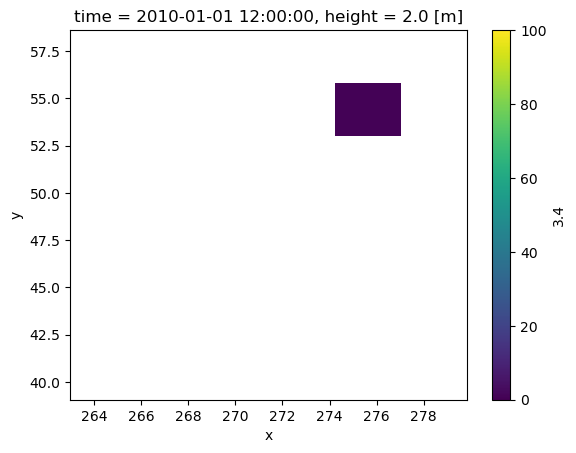

In [178]:
confi_ds_shift[name + "." + str(rot + 1)].unstack("stacked_coords")[0, :, :].plot(
    vmin=0, vmax=100
)

In [174]:
confi_ds["2.1"]

<xarray.DataArray '2.1' (time: 10, y: 7, x: 6)> Size: 3kB
dask.array<reshape, shape=(10, 7, 6), dtype=float64, chunksize=(10, 7, 6), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 56B 40.46 43.25 46.04 48.84 51.63 54.42 57.21
  * x        (x) float64 48B 264.4 267.2 270.0 272.8 275.6 278.4
  * time     (time) object 80B 2010-01-01 12:00:00 ... 2010-01-10 12:00:00
    height   float64 8B 2.0

In [171]:
xr.concat(confi_list, dim="stacked_coords").drop_duplicates("stacked_coords").chunk(
    None
).unstack("stacked_coords")

<xarray.Dataset> Size: 17kB
Dimensions:  (y: 7, x: 5, time: 10)
Coordinates:
  * y        (y) float64 56B 40.46 43.25 46.04 48.84 51.63 54.42 57.21
  * x        (x) float64 40B 264.4 267.2 270.0 272.8 275.6
    height   float64 8B ...
  * time     (time) object 80B 2010-01-01 12:00:00 ... 2010-01-10 12:00:00
Data variables:
    2.1      (time, y, x) float64 3kB dask.array<chunksize=(10, 1, 5), meta=np.ndarray>
    2.2      (time, y, x) float64 3kB dask.array<chunksize=(10, 1, 5), meta=np.ndarray>
    3.1      (time, y, x) float64 3kB dask.array<chunksize=(10, 7, 5), meta=np.ndarray>
    3.2      (time, y, x) float64 3kB dask.array<chunksize=(10, 7, 5), meta=np.ndarray>
    3.3      (time, y, x) float64 3kB dask.array<chunksize=(10, 7, 5), meta=np.ndarray>
    3.4      (time, y, x) float64 3kB dask.array<chunksize=(10, 7, 5), meta=np.ndarray>

In [167]:
confi_list[0]["2.1"]

<xarray.DataArray '2.1' (time: 10, stacked_coords: 1)> Size: 80B
dask.array<reshape, shape=(10, 1), dtype=float64, chunksize=(10, 1), chunktype=numpy.ndarray>
Coordinates:
    height          float64 8B ...
  * time            (time) object 80B 2010-01-01 12:00:00 ... 2010-01-10 12:0...
  * stacked_coords  (stacked_coords) object 8B MultiIndex
  * y               (stacked_coords) float64 8B 40.46
  * x               (stacked_coords) float64 8B 264.4

In [162]:
da

<xarray.DataArray 'pr' (time: 10, y: 7, x: 6)> Size: 3kB
dask.array<getitem, shape=(10, 7, 6), dtype=float64, chunksize=(10, 7, 6), chunktype=numpy.ndarray>
Coordinates:
    height   float64 8B ...
  * time     (time) object 80B 2010-01-01 12:00:00 ... 2010-01-10 12:00:00
  * x        (x) float64 48B 264.4 267.2 270.0 272.8 275.6 278.4
  * y        (y) float64 56B 40.46 43.25 46.04 48.84 51.63 54.42 57.21

In [157]:
da.shape

(10, 7, 6)

In [159]:
confi_ds

<xarray.Dataset> Size: 17kB
Dimensions:  (y: 7, x: 5, time: 10)
Coordinates:
  * y        (y) float64 56B 40.46 43.25 46.04 48.84 51.63 54.42 57.21
  * x        (x) float64 40B 264.4 267.2 270.0 272.8 275.6
    height   float64 8B ...
  * time     (time) object 80B 2010-01-01 12:00:00 ... 2010-01-10 12:00:00
Data variables:
    2.1      (time, y, x) float64 3kB dask.array<chunksize=(10, 1, 5), meta=np.ndarray>
    2.2      (time, y, x) float64 3kB dask.array<chunksize=(10, 1, 5), meta=np.ndarray>
    3.1      (time, y, x) float64 3kB dask.array<chunksize=(10, 7, 5), meta=np.ndarray>
    3.2      (time, y, x) float64 3kB dask.array<chunksize=(10, 7, 5), meta=np.ndarray>
    3.3      (time, y, x) float64 3kB dask.array<chunksize=(10, 7, 5), meta=np.ndarray>
    3.4      (time, y, x) float64 3kB dask.array<chunksize=(10, 7, 5), meta=np.ndarray>

In [161]:
confi_ds["2.1"]

<xarray.DataArray '2.1' (time: 10, y: 7, x: 5)> Size: 3kB
dask.array<reshape, shape=(10, 7, 5), dtype=float64, chunksize=(10, 1, 5), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 56B 40.46 43.25 46.04 48.84 51.63 54.42 57.21
  * x        (x) float64 40B 264.4 267.2 270.0 272.8 275.6
    height   float64 8B ...
  * time     (time) object 80B 2010-01-01 12:00:00 ... 2010-01-10 12:00:00

In [147]:
xr.concat(LIST, dim="stacked_coords")

<xarray.Dataset> Size: 30kB
Dimensions:         (time: 10, stacked_coords: 60)
Coordinates:
    height          float64 8B ...
  * time            (time) object 80B 2010-01-01 12:00:00 ... 2010-01-10 12:0...
  * stacked_coords  (stacked_coords) object 480B MultiIndex
  * y               (stacked_coords) float64 480B 40.46 40.46 ... 54.42 54.42
  * x               (stacked_coords) float64 480B 264.4 267.2 ... 272.8 275.6
Data variables:
    2.1             (time, stacked_coords) float64 5kB dask.array<chunksize=(10, 1), meta=np.ndarray>
    2.2             (time, stacked_coords) float64 5kB dask.array<chunksize=(10, 1), meta=np.ndarray>
    3.1             (time, stacked_coords) float64 5kB dask.array<chunksize=(10, 36), meta=np.ndarray>
    3.2             (time, stacked_coords) float64 5kB dask.array<chunksize=(10, 36), meta=np.ndarray>
    3.3             (time, stacked_coords) float64 5kB dask.array<chunksize=(10, 36), meta=np.ndarray>
    3.4             (time, stacked_coords) float64 5kB dask.array<chunksize=(10, 36), meta=np.ndarray>

In [154]:
xr.concat(LIST, dim="stacked_coords", data_vars="different")

<xarray.Dataset> Size: 30kB
Dimensions:         (time: 10, stacked_coords: 60)
Coordinates:
    height          float64 8B ...
  * time            (time) object 80B 2010-01-01 12:00:00 ... 2010-01-10 12:0...
  * stacked_coords  (stacked_coords) object 480B MultiIndex
  * y               (stacked_coords) float64 480B 40.46 40.46 ... 54.42 54.42
  * x               (stacked_coords) float64 480B 264.4 267.2 ... 272.8 275.6
Data variables:
    2.1             (time, stacked_coords) float64 5kB dask.array<chunksize=(10, 1), meta=np.ndarray>
    2.2             (time, stacked_coords) float64 5kB dask.array<chunksize=(10, 1), meta=np.ndarray>
    3.1             (time, stacked_coords) float64 5kB dask.array<chunksize=(10, 36), meta=np.ndarray>
    3.2             (time, stacked_coords) float64 5kB dask.array<chunksize=(10, 36), meta=np.ndarray>
    3.3             (time, stacked_coords) float64 5kB dask.array<chunksize=(10, 36), meta=np.ndarray>
    3.4             (time, stacked_coords) float64 5kB dask.array<chunksize=(10, 36), meta=np.ndarray>

In [138]:
confi_ds

<xarray.Dataset> Size: 18kB
Dimensions:         (time: 10, stacked_coords: 35)
Coordinates:
    height          float64 8B ...
  * time            (time) object 80B 2010-01-01 12:00:00 ... 2010-01-10 12:0...
  * stacked_coords  (stacked_coords) object 280B MultiIndex
  * y               (stacked_coords) float64 280B 40.46 40.46 ... 57.21 57.21
  * x               (stacked_coords) float64 280B 264.4 267.2 ... 272.8 275.6
Data variables:
    2.1             (time, stacked_coords) float64 3kB dask.array<chunksize=(10, 1), meta=np.ndarray>
    2.2             (time, stacked_coords) float64 3kB dask.array<chunksize=(10, 1), meta=np.ndarray>
    3.1             (time, stacked_coords) float64 3kB dask.array<chunksize=(10, 35), meta=np.ndarray>
    3.2             (time, stacked_coords) float64 3kB dask.array<chunksize=(10, 35), meta=np.ndarray>
    3.3             (time, stacked_coords) float64 3kB dask.array<chunksize=(10, 35), meta=np.ndarray>
    3.4             (time, stacked_coords) float64 3kB dask.array<chunksize=(10, 35), meta=np.ndarray>

In [137]:
xr.concat(LIST, dim="xy")

<xarray.Dataset> Size: 1MB
Dimensions:         (xy: 60, time: 10, stacked_coords: 35)
Coordinates:
  * time            (time) object 80B 2010-01-01 12:00:00 ... 2010-01-10 12:0...
  * stacked_coords  (stacked_coords) object 280B MultiIndex
  * y               (stacked_coords) float64 280B 40.46 40.46 ... 57.21 57.21
  * x               (stacked_coords) float64 280B 264.4 267.2 ... 272.8 275.6
    height          float64 8B ...
Dimensions without coordinates: xy
Data variables:
    2.1             (xy, time, stacked_coords) float64 168kB dask.array<chunksize=(1, 10, 35), meta=np.ndarray>
    2.2             (xy, time, stacked_coords) float64 168kB dask.array<chunksize=(1, 10, 35), meta=np.ndarray>
    3.1             (xy, time, stacked_coords) float64 168kB dask.array<chunksize=(36, 10, 35), meta=np.ndarray>
    3.2             (xy, time, stacked_coords) float64 168kB dask.array<chunksize=(36, 10, 35), meta=np.ndarray>
    3.3             (xy, time, stacked_coords) float64 168kB dask.array<chunksize=(36, 10, 35), meta=np.ndarray>
    3.4             (xy, time, stacked_coords) float64 168kB dask.array<chunksize=(36, 10, 35), meta=np.ndarray>

In [122]:
xr.concat(LIST, dim="stacked_coords")

<xarray.Dataset> Size: 1MB
Dimensions:  (stacked_coords: 60, time: 10, xy: 35)
Coordinates:
  * time     (time) object 80B 2010-01-01 12:00:00 ... 2010-01-10 12:00:00
  * xy       (xy) object 280B MultiIndex
  * y        (xy) float64 280B 40.46 40.46 40.46 40.46 ... 57.21 57.21 57.21
  * x        (xy) float64 280B 264.4 267.2 270.0 272.8 ... 270.0 272.8 275.6
    height   float64 8B ...
Dimensions without coordinates: stacked_coords
Data variables:
    2.1      (stacked_coords, time, xy) float64 168kB dask.array<chunksize=(1, 10, 35), meta=np.ndarray>
    2.2      (stacked_coords, time, xy) float64 168kB dask.array<chunksize=(1, 10, 35), meta=np.ndarray>
    3.1      (stacked_coords, time, xy) float64 168kB dask.array<chunksize=(36, 10, 35), meta=np.ndarray>
    3.2      (stacked_coords, time, xy) float64 168kB dask.array<chunksize=(36, 10, 35), meta=np.ndarray>
    3.3      (stacked_coords, time, xy) float64 168kB dask.array<chunksize=(36, 10, 35), meta=np.ndarray>
    3.4      (stacked_coords, time, xy) float64 168kB dask.array<chunksize=(36, 10, 35), meta=np.ndarray>

In [119]:
xr.concat(LIST, dim="stacked_coords").drop_duplicates("stacked_coords")["2.1"].values

array([[2.24561987e-01, 5.04520447e-01, 1.15048112e+00, 1.91719329e+00,
        2.31348668e+00, 2.70528929e-01, 3.64428772e-01, 2.14355485e-01,
        1.96272152e+00, 3.04945029e+00, 4.96020121e-01, 2.66063157e-01,
        3.06634326e-01, 2.12415975e-01, 2.05048817e+00, 2.48227448e-01,
        3.52620779e-01, 1.56803543e-01, 8.80371840e-03, 2.29897500e-01,
        1.98538625e-02, 1.98538884e-02, 1.53506638e-04, 2.16600486e-02,
        2.17406202e-01, 3.87902764e-01, 1.58895057e-01, 3.15525324e-01,
        6.04455532e-01, 3.86918741e-01, 2.69526222e-01, 1.35745955e-01,
        1.77732316e-01, 6.79200053e-01, 1.17659843e+00],
       [1.50717638e-06, 7.04378880e-03, 7.04311895e-03, 5.43420818e-05,
        6.59415975e-01, 6.90663588e-04, 1.61158602e-01, 5.20794106e-01,
        6.73202212e-01, 6.47599872e-01, 2.63064202e-01, 9.11243015e-02,
        1.00260848e-01, 1.27872529e-01, 1.01803780e-01, 4.64797253e-01,
        1.23162392e-01, 2.70752093e-02, 1.29281612e-01, 2.17801390e-01,
       

In [118]:
xr.concat(LIST, dim="stacked_coords")["2.1"].values

array([[2.24561987e-01, 5.04520447e-01, 1.15048112e+00, 1.91719329e+00,
        2.31348668e+00, 2.70528929e-01, 3.64428772e-01, 2.14355485e-01,
        1.96272152e+00, 3.04945029e+00, 4.96020121e-01, 2.66063157e-01,
        3.06634326e-01, 2.12415975e-01, 2.05048817e+00, 2.48227448e-01,
        3.52620779e-01, 1.56803543e-01, 8.80371840e-03, 2.29897500e-01,
        1.98538625e-02, 1.98538884e-02, 1.53506638e-04, 2.16600486e-02,
        2.17406202e-01, 3.87902764e-01, 1.58895057e-01, 3.15525324e-01,
        6.04455532e-01, 3.86918741e-01, 2.69526222e-01, 1.35745955e-01,
        1.77732316e-01, 6.79200053e-01, 1.17659843e+00,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,         

In [113]:
confi_ds

<xarray.Dataset> Size: 18kB
Dimensions:         (time: 10, stacked_coords: 35)
Coordinates:
    height          float64 8B ...
  * time            (time) object 80B 2010-01-01 12:00:00 ... 2010-01-10 12:0...
  * stacked_coords  (stacked_coords) object 280B MultiIndex
  * y               (stacked_coords) float64 280B 40.46 40.46 ... 57.21 57.21
  * x               (stacked_coords) float64 280B 264.4 267.2 ... 272.8 275.6
Data variables:
    2.1             (time, stacked_coords) float64 3kB dask.array<chunksize=(10, 1), meta=np.ndarray>
    2.2             (time, stacked_coords) float64 3kB dask.array<chunksize=(10, 1), meta=np.ndarray>
    3.1             (time, stacked_coords) float64 3kB dask.array<chunksize=(10, 35), meta=np.ndarray>
    3.2             (time, stacked_coords) float64 3kB dask.array<chunksize=(10, 35), meta=np.ndarray>
    3.3             (time, stacked_coords) float64 3kB dask.array<chunksize=(10, 35), meta=np.ndarray>
    3.4             (time, stacked_coords) float64 3kB dask.array<chunksize=(10, 35), meta=np.ndarray>

In [123]:
LIST[0]

<xarray.Dataset> Size: 272B
Dimensions:  (time: 10, xy: 1)
Coordinates:
    height   float64 8B ...
  * time     (time) object 80B 2010-01-01 12:00:00 ... 2010-01-10 12:00:00
  * xy       (xy) object 8B MultiIndex
  * y        (xy) float64 8B 40.46
  * x        (xy) float64 8B 264.4
Data variables:
    2.1      (time, xy) float64 80B dask.array<chunksize=(10, 1), meta=np.ndarray>
    2.2      (time, xy) float64 80B dask.array<chunksize=(10, 1), meta=np.ndarray>

In [105]:
LIST[1]

<xarray.Dataset> Size: 272B
Dimensions:         (time: 10, stacked_coords: 1)
Coordinates:
    height          float64 8B ...
  * time            (time) object 80B 2010-01-01 12:00:00 ... 2010-01-10 12:0...
  * stacked_coords  (stacked_coords) object 8B MultiIndex
  * y               (stacked_coords) float64 8B 40.46
  * x               (stacked_coords) float64 8B 264.4
Data variables:
    2.1             (time, stacked_coords) float64 80B dask.array<chunksize=(10, 1), meta=np.ndarray>
    2.2             (time, stacked_coords) float64 80B dask.array<chunksize=(10, 1), meta=np.ndarray>

In [14]:
from copy import deepcopy

import xclim

In [858]:
matrix_mask

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan,  1.,  1.,  1.,  1.],
       [nan, nan, nan, nan, nan,  1.,  1.,  1.,  1.],
       [nan, nan, nan, nan, nan,  1.,  1.,  1.,  1.],
       [nan, nan, nan, nan, nan,  1.,  1.,  1.,  1.],
       [nan, nan, nan, nan, nan,  1.,  1.,  1.,  1.]])

In [13]:
def _rotate_around_center(matrix, center, k=1):
    """
    Rotate a matrix around a given center point by 90 degrees k times.

    Parameters:
    - matrix: 2D numpy array to be rotated.
    - center: Tuple (row, col) indicating the center of rotation.
    - k: Number of 90-degree clockwise rotations.

    Returns:
    - Rotated 2D numpy array.
    """

    def _rotate_point_n_times(py, px, cy, cx, n):
        """
        Rotate a point (px, py) by 90 degrees counterclockwise around a center point (cx, cy)
        for n times.

        Args:
        px (float): The x-coordinate of the point to be rotated.
        py (float): The y-coordinate of the point to be rotated.
        cx (float): The x-coordinate of the center of rotation.
        cy (float): The y-coordinate of the center of rotation.
        n (int): The number of 90-degree rotations.

        Returns:
        tuple: The new coordinates of the point after rotation.
        """
        # Normalize n to be within [0, 3] to avoid unnecessary rotations
        n = n % 4

        # Translate point to origin (subtract the center coordinates)
        translated_x = px - cx
        translated_y = py - cy

        # Rotate point n times
        for _ in range(n):
            translated_x, translated_y = -translated_y, translated_x

        # Translate point back to original coordinates
        final_x = translated_x + cx
        final_y = translated_y + cy

        return (final_y, final_x)

    matrix = np.array(matrix)
    rows, cols = matrix.shape
    rotated_matrix = np.full_like(matrix, np.nan)

    center_row, center_col = center

    for r in range(rows):
        for c in range(cols):
            if not np.isnan(matrix[r, c]):
                new_r, new_c = _rotate_point_n_times(r, c, center_row, center_col, k)
                if 0 <= new_r < rows and 0 <= new_c < cols:
                    rotated_matrix[new_r, new_c] = matrix[r, c]

    return rotated_matrix

In [857]:
"""Compute the spatial average for different storm configurations proposed by Clavet-Gaumont et al. (2017).

Parameters
----------
da : xr.DataArray
    DataArray containing the precipitation values.
radius : float
    Maximum radius of the storm.

Returns
-------
xr.DataSet
    DataSet contaning the spatial averages for all the storm configurations.

Notes
-----
https://doi.org/10.1016/j.ejrh.2017.07.003.
"""

'Compute the spatial average for different storm configurations proposed by Clavet-Gaumont et al. (2017).\n\nParameters\n----------\nda : xr.DataArray\n    DataArray containing the precipitation values.\nradius : float\n    Maximum radius of the storm.\n\nReturns\n-------\nxr.DataSet\n    DataSet contaning the spatial averages for all the storm configurations.\n\nNotes\n-----\nhttps://doi.org/10.1016/j.ejrh.2017.07.003.\n'